In [1]:
import os
from pathlib import Path
import json
import random
import numpy as np
import joblib
import rasterio
from rasterio.enums import Resampling
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

Define Paths and Config

In [ ]:
processed_dir = Path("../data/processed/spread")  
structured_dir = Path("../data/structured/spread")   
structured_dir.mkdir(parents=True, exist_ok=True)

fire_events = [p.name for p in processed_dir.iterdir() if p.is_dir()]
fire_events = sorted(fire_events)
print("Found fire events:", fire_events)

patch_size = 64
overlap = 0           
min_burned_pixels_per_patch = 1

save_tabular = True
save_cnn_tensors = True

random_seed = 42
np.random.seed(random_seed)
random.seed(random_seed)

Found fire events: ['Bootleg', 'Caldor', 'Camp', 'Carr', 'Creek', 'Dixie', 'Glass', 'Thomas', 'Troublesome', 'Woolsey']


Helper Functions

In [ ]:
def load_npy(path):
    arr = np.load(path)
    return arr

def load_tif_profile(path):
    with rasterio.open(path) as src:
        profile = src.profile
    return profile

def sliding_window_indices(h, w, patch_size, overlap=0):
    """Yield (row_start, row_end, col_start, col_end) for tiling a [h,w] image."""
    stride = patch_size - overlap
    if stride <= 0:
        raise ValueError("overlap must be < patch_size")
    for r in range(0, max(1, h - patch_size + 1), stride):
        for c in range(0, max(1, w - patch_size + 1), stride):
            yield r, r + patch_size, c, c + patch_size
    if h % stride != 0:
        r = max(0, h - patch_size)
        for c in range(0, max(1, w - patch_size + 1), stride):
            yield r, r + patch_size, c, c + patch_size
    if w % stride != 0:
        c = max(0, w - patch_size)
        for r in range(0, max(1, h - patch_size + 1), stride):
            yield r, r + patch_size, c, c + patch_size
    if (h % stride != 0) and (w % stride != 0):
        yield max(0, h - patch_size), h, max(0, w - patch_size), w

def patch_stats(patch_target):
    """Return burned pixels and fraction for a patch target (binary mask)."""
    burned = np.sum(patch_target == 1)
    frac = burned / (patch_target.size + 1e-9)
    return burned, frac

Main Processing Loop per fire


=== Structuring: Bootleg ===
Loaded features shape: (402, 542, 5)  target shape: (402, 542)
Non-temporal data detected. Building spatial patches (static prediction).
Generated 49 patches for Bootleg. Patch shape: (64, 64, 5)
Saved CNN tensors to: ..\data\structured\spread\Bootleg\cnn_patches.npz
Saved tabular pickled dataset to: ..\data\structured\spread\Bootleg\tabular_patches.pkl


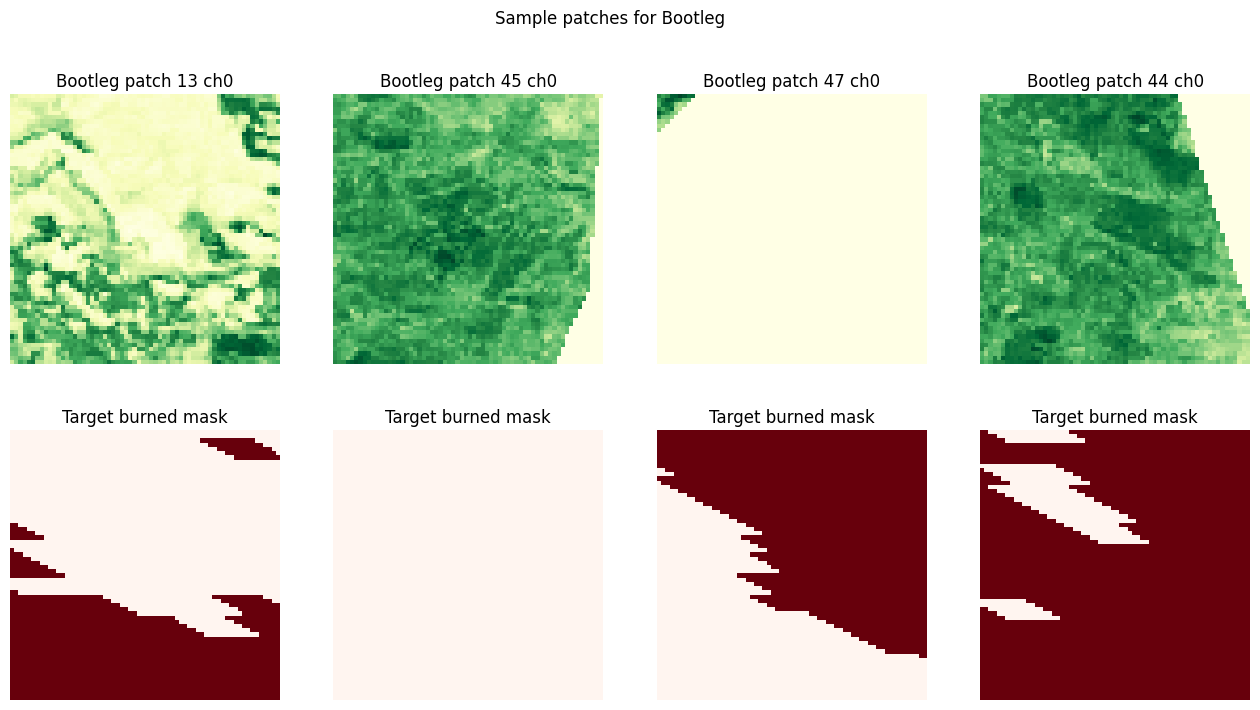


=== Structuring: Caldor ===
Loaded features shape: (401, 511, 5)  target shape: (401, 511)
Non-temporal data detected. Building spatial patches (static prediction).
Generated 24 patches for Caldor. Patch shape: (64, 64, 5)
Saved CNN tensors to: ..\data\structured\spread\Caldor\cnn_patches.npz
Saved tabular pickled dataset to: ..\data\structured\spread\Caldor\tabular_patches.pkl


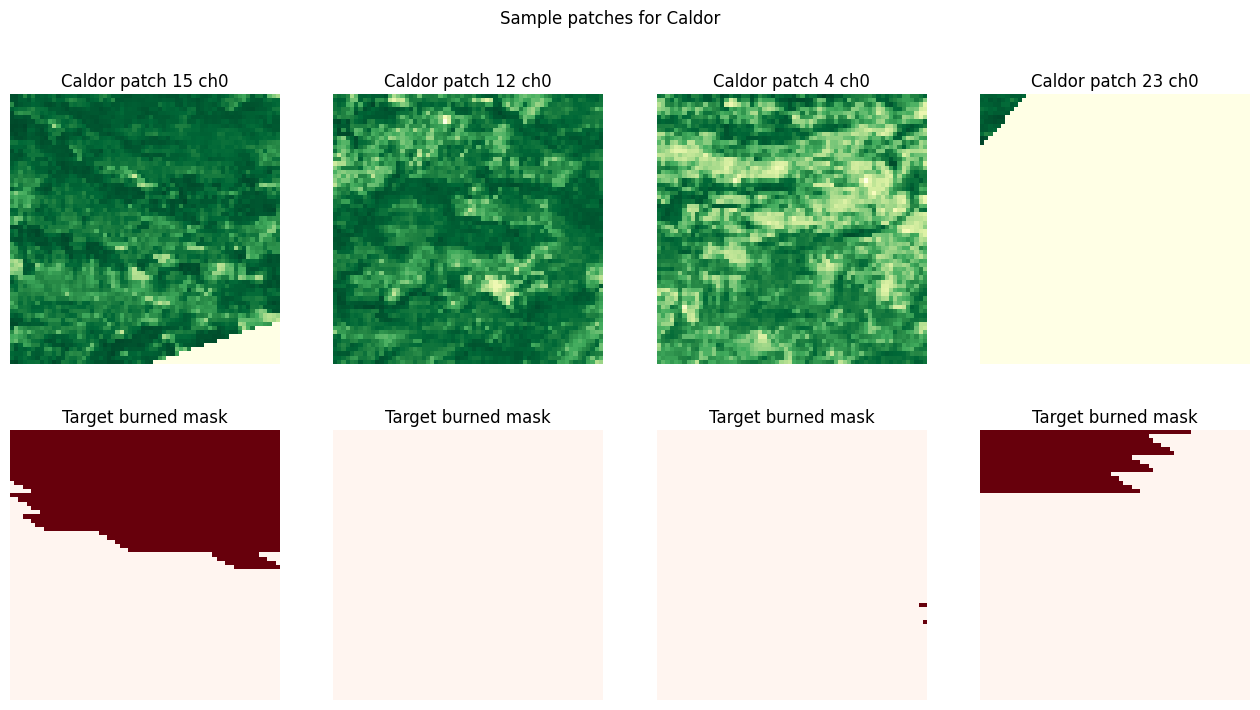


=== Structuring: Camp ===
Loaded features shape: (501, 652, 5)  target shape: (501, 652)
Non-temporal data detected. Building spatial patches (static prediction).
Generated 30 patches for Camp. Patch shape: (64, 64, 5)
Saved CNN tensors to: ..\data\structured\spread\Camp\cnn_patches.npz
Saved tabular pickled dataset to: ..\data\structured\spread\Camp\tabular_patches.pkl


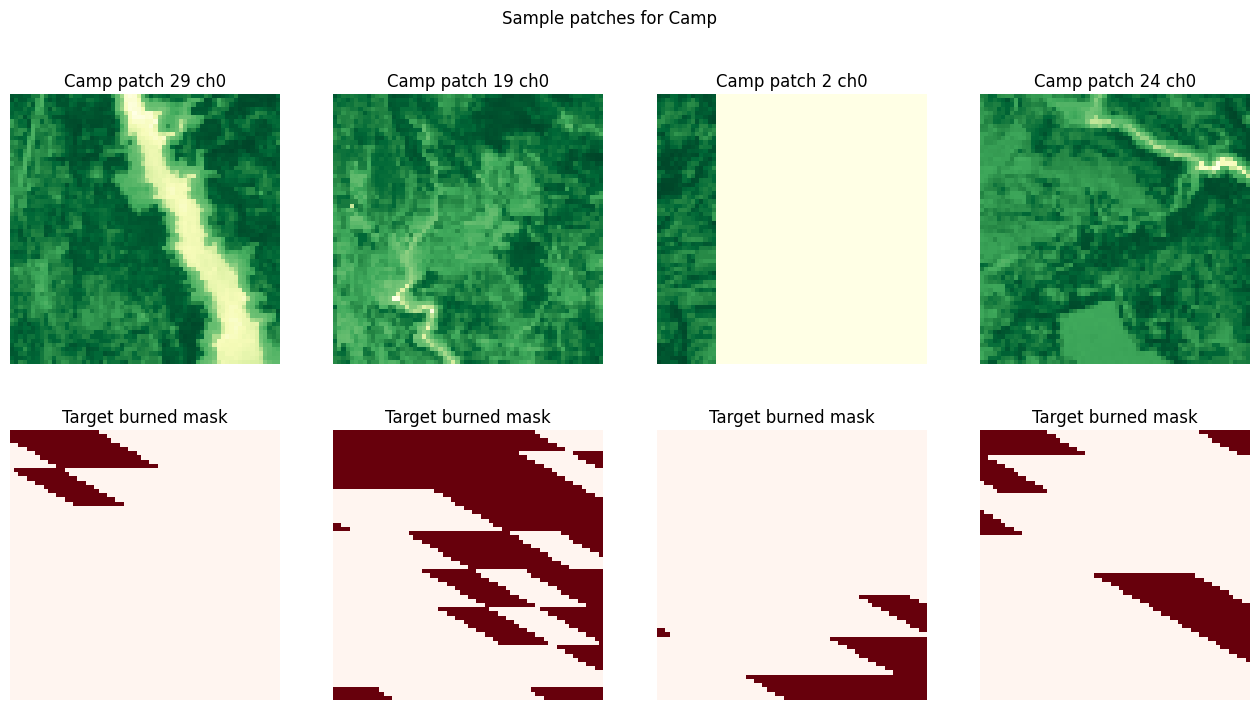


=== Structuring: Carr ===
Loaded features shape: (402, 526, 5)  target shape: (402, 526)
Non-temporal data detected. Building spatial patches (static prediction).
Generated 48 patches for Carr. Patch shape: (64, 64, 5)
Saved CNN tensors to: ..\data\structured\spread\Carr\cnn_patches.npz
Saved tabular pickled dataset to: ..\data\structured\spread\Carr\tabular_patches.pkl


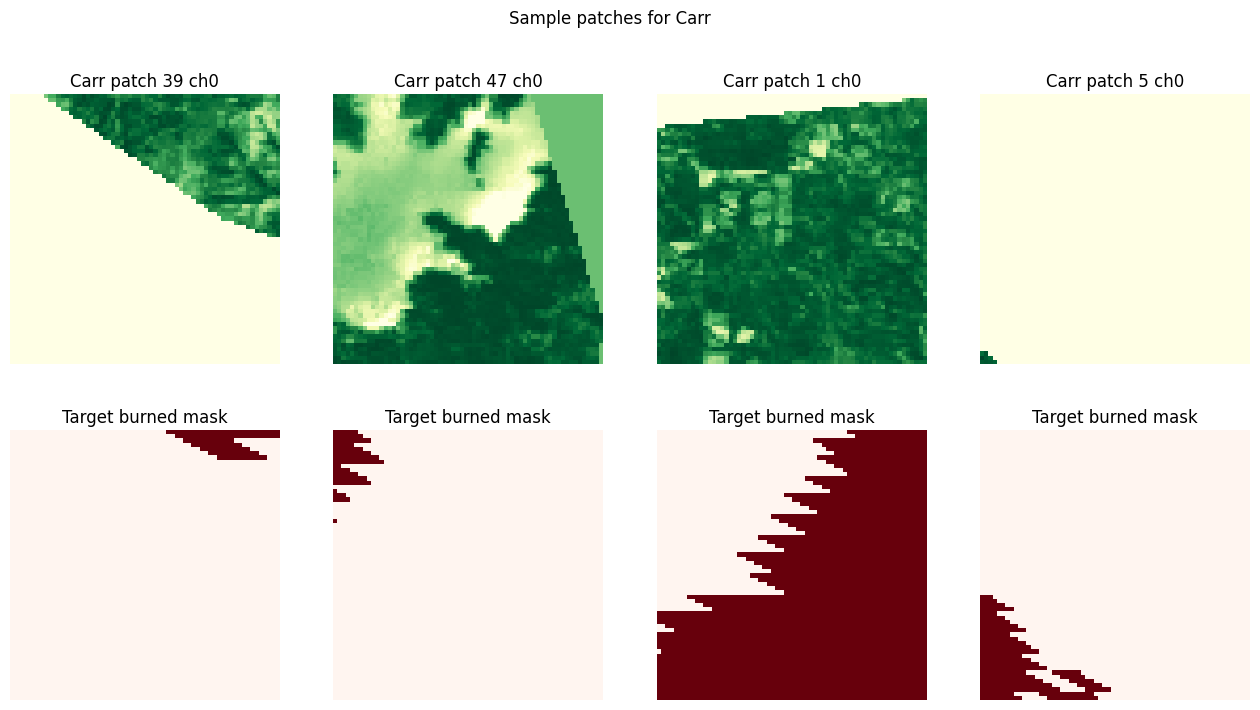


=== Structuring: Creek ===
Loaded features shape: (402, 501, 5)  target shape: (402, 501)
Non-temporal data detected. Building spatial patches (static prediction).
Generated 28 patches for Creek. Patch shape: (64, 64, 5)
Saved CNN tensors to: ..\data\structured\spread\Creek\cnn_patches.npz
Saved tabular pickled dataset to: ..\data\structured\spread\Creek\tabular_patches.pkl


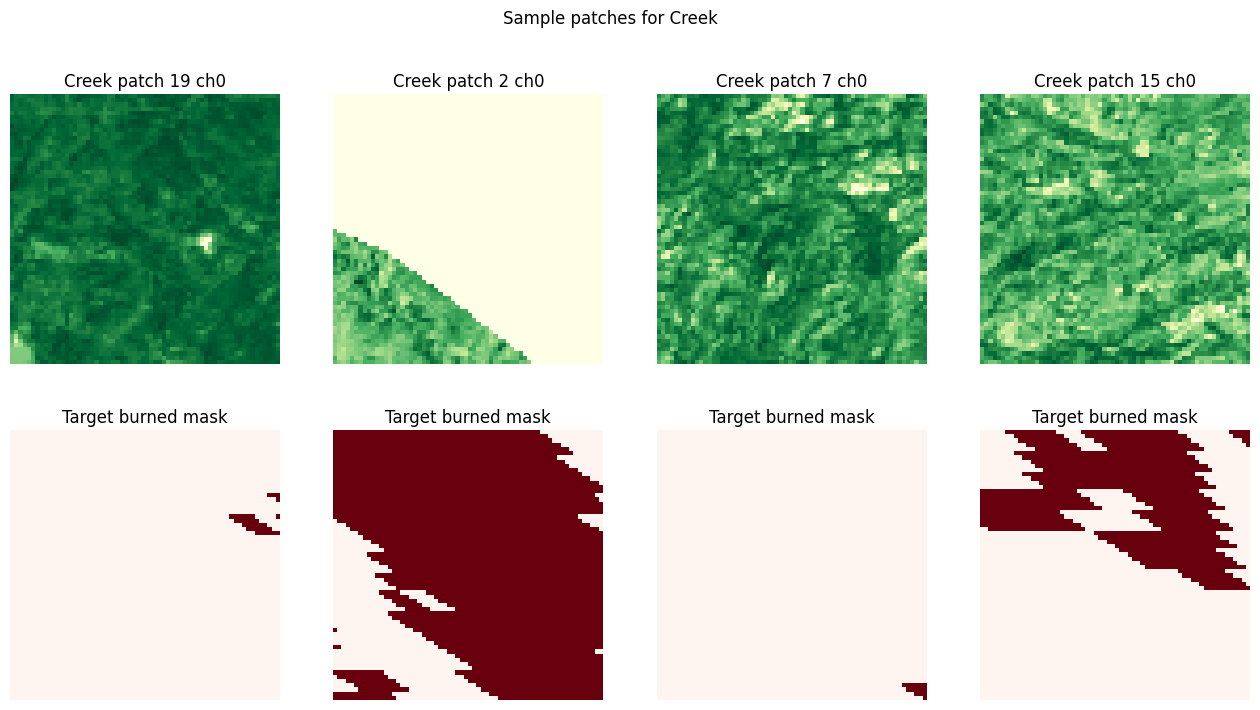


=== Structuring: Dixie ===
Loaded features shape: (402, 520, 5)  target shape: (402, 520)
Non-temporal data detected. Building spatial patches (static prediction).
Generated 28 patches for Dixie. Patch shape: (64, 64, 5)
Saved CNN tensors to: ..\data\structured\spread\Dixie\cnn_patches.npz
Saved tabular pickled dataset to: ..\data\structured\spread\Dixie\tabular_patches.pkl


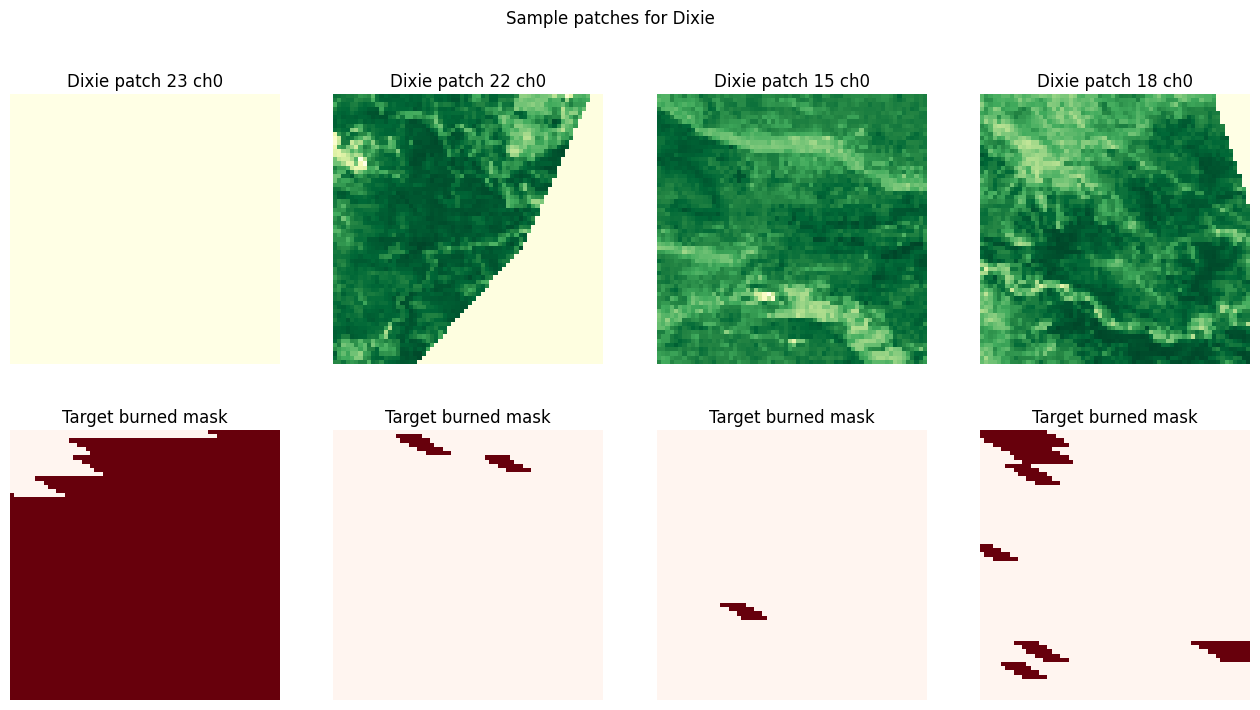


=== Structuring: Glass ===
Loaded features shape: (401, 511, 5)  target shape: (401, 511)
Non-temporal data detected. Building spatial patches (static prediction).
Generated 17 patches for Glass. Patch shape: (64, 64, 5)
Saved CNN tensors to: ..\data\structured\spread\Glass\cnn_patches.npz
Saved tabular pickled dataset to: ..\data\structured\spread\Glass\tabular_patches.pkl


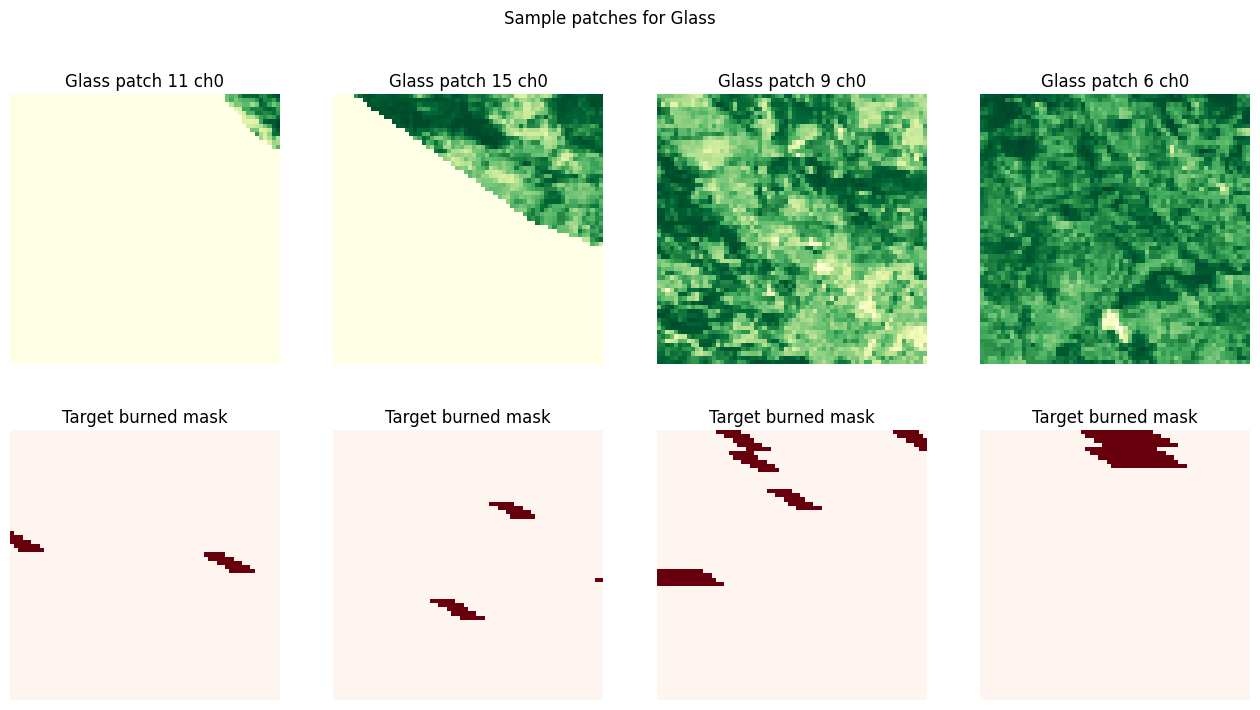


=== Structuring: Thomas ===
Loaded features shape: (402, 484, 5)  target shape: (402, 484)
Non-temporal data detected. Building spatial patches (static prediction).
[No patches] No patches generated for Thomas (check min_burned_pixels_per_patch).

=== Structuring: Troublesome ===
Loaded features shape: (401, 522, 5)  target shape: (401, 522)
Non-temporal data detected. Building spatial patches (static prediction).
Generated 1 patches for Troublesome. Patch shape: (64, 64, 5)
Saved CNN tensors to: ..\data\structured\spread\Troublesome\cnn_patches.npz
Saved tabular pickled dataset to: ..\data\structured\spread\Troublesome\tabular_patches.pkl


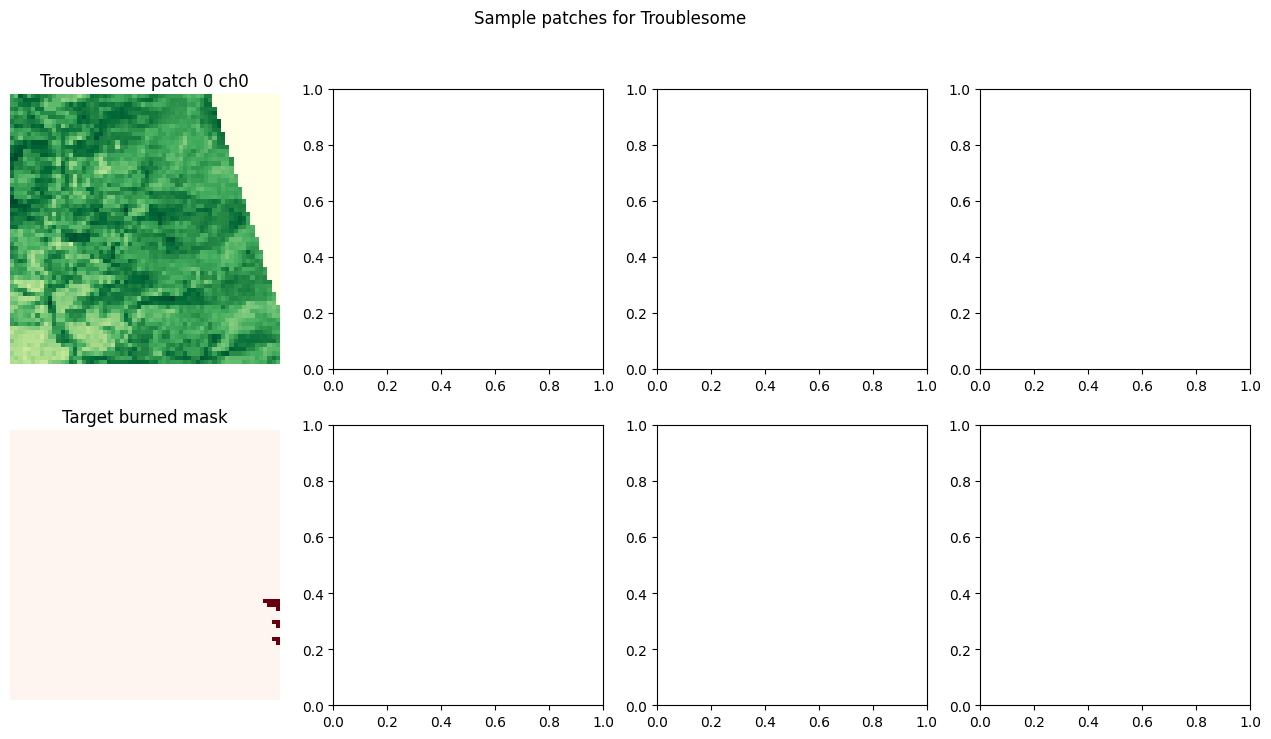


=== Structuring: Woolsey ===
Loaded features shape: (501, 605, 5)  target shape: (501, 605)
Non-temporal data detected. Building spatial patches (static prediction).
Generated 25 patches for Woolsey. Patch shape: (64, 64, 5)
Saved CNN tensors to: ..\data\structured\spread\Woolsey\cnn_patches.npz
Saved tabular pickled dataset to: ..\data\structured\spread\Woolsey\tabular_patches.pkl


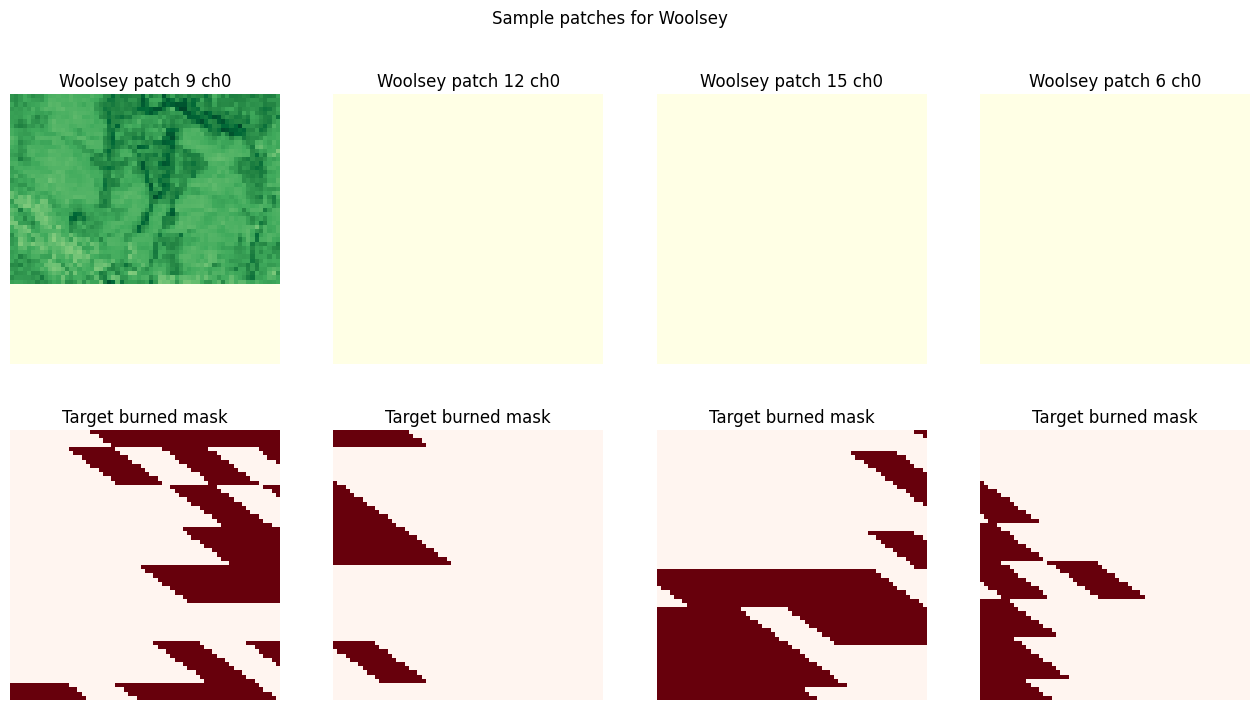


Structured datasets saved under: ..\data\structured\spread


In [5]:
global_summary = []

for fire in fire_events:
    print("\n=== Structuring:", fire, "===")
    fire_input_dir = processed_dir / fire
    if not fire_input_dir.exists():
        print(f"[Missing folder] {fire_input_dir} - skipping")
        continue

    features_path = fire_input_dir / "features.npy"
    target_path   = fire_input_dir / "target.npy"
    tif_path      = fire_input_dir / "stacked_features.tif"

    if not features_path.exists() or not target_path.exists():
        print(f"[Missing files] features/target missing for {fire}, skipping")
        continue

    features = load_npy(features_path)
    target   = load_npy(target_path) 

    print("Loaded features shape:", features.shape, " target shape:", target.shape)

    is_temporal = (features.ndim == 4 and target.ndim == 3 and features.shape[0] == target.shape[0])

    fire_out_dir = structured_dir / fire
    fire_out_dir.mkdir(parents=True, exist_ok=True)

    metadata = {
        "fire": fire,
        "input_shape": features.shape,
        "target_shape": target.shape,
        "is_temporal": is_temporal,
        "patch_size": patch_size,
        "overlap": overlap,
        "min_burned_pixels_per_patch": min_burned_pixels_per_patch
    }

    X_patches = [] 
    y_patches = []  
    tabular_rows = [] 

    # ---------- Temporal path ---------- #
    if is_temporal:
        print("Detected temporal time-series data. Building Day N -> Day N+1 pairs.")
        T, H, W, C = features.shape
        for t in tqdm(range(T - 1), desc="Time steps"):
            feat_t = features[t]     
            targ_t1 = target[t + 1]  

            for r0, r1, c0, c1 in sliding_window_indices(H, W, patch_size, overlap):
                patch_X = feat_t[r0:r1, c0:c1, :]   
                patch_Y = targ_t1[r0:r1, c0:c1]    
                burned_count, frac = patch_stats(patch_Y)

                if burned_count < min_burned_pixels_per_patch:
                    continue

                X_patches.append(patch_X.astype(np.float32))
                y_patches.append((patch_Y > 0).astype(np.uint8))

                flat = patch_X.reshape(-1)
                tabular_rows.append({
                    "patch_flat": flat,           
                    "burned_frac": float(frac),
                    "burned_count": int(burned_count),
                    "r0": int(r0), "r1": int(r1), "c0": int(c0), "c1": int(c1), "time_index": int(t)
                })

    # ---------- Static path ---------- #
    else:
        print("Non-temporal data detected. Building spatial patches (static prediction).")
        H, W, C = features.shape

        if target.ndim != 2:
            if target.ndim == 3 and target.shape[0] == 1:
                target_2d = target[0]
            else:
                print("[Warning] target shape unexpected; converting to 2D by taking max over time if possible.")
                try:
                    target_2d = np.max(target, axis=0)
                except Exception:
                    raise RuntimeError(f"Cannot coerce target to 2D for fire {fire}")
        else:
            target_2d = target

        for r0, r1, c0, c1 in sliding_window_indices(H, W, patch_size, overlap):
            patch_X = features[r0:r1, c0:c1, :]
            patch_Y = target_2d[r0:r1, c0:c1]
            burned_count, frac = patch_stats(patch_Y)

            if burned_count < min_burned_pixels_per_patch:
                continue

            X_patches.append(patch_X.astype(np.float32))
            y_patches.append((patch_Y > 0).astype(np.uint8))

            flat = patch_X.reshape(-1)
            tabular_rows.append({
                "patch_flat": flat,
                "burned_frac": float(frac),
                "burned_count": int(burned_count),
                "r0": int(r0), "r1": int(r1), "c0": int(c0), "c1": int(c1)
            })

    if len(X_patches) == 0:
        print(f"[No patches] No patches generated for {fire} (check min_burned_pixels_per_patch).")
        metadata["num_patches"] = 0
        with open(fire_out_dir / "metadata.json", "w") as f:
            json.dump(metadata, f, indent=2)
        global_summary.append(metadata)
        continue

    X_array = np.stack(X_patches, axis=0)  
    y_array = np.stack(y_patches, axis=0)  

    print(f"Generated {X_array.shape[0]} patches for {fire}. Patch shape:", X_array.shape[1:])

    if save_cnn_tensors:
        np.savez_compressed(fire_out_dir / "cnn_patches.npz", X=X_array, y=y_array)
        print("Saved CNN tensors to:", fire_out_dir / "cnn_patches.npz")

    if save_tabular:
        X_tab = np.stack([r["patch_flat"] for r in tabular_rows], axis=0)
        burned_fracs = np.array([r["burned_frac"] for r in tabular_rows], dtype=np.float32)
        y_tab = (burned_fracs > 0).astype(np.uint8)

        tabular_obj = {"X": X_tab, "y": y_tab, "meta_rows": tabular_rows}
        joblib.dump(tabular_obj, fire_out_dir / "tabular_patches.pkl")
        print("Saved tabular pickled dataset to:", fire_out_dir / "tabular_patches.pkl")

    metadata["num_patches"] = int(X_array.shape[0])
    metadata["patch_shape"] = list(X_array.shape[1:])
    metadata["channels"] = int(X_array.shape[-1])
    metadata["cnn_tensors_path"] = str(fire_out_dir / "cnn_patches.npz") if save_cnn_tensors else None
    metadata["tabular_path"] = str(fire_out_dir / "tabular_patches.pkl") if save_tabular else None

    with open(fire_out_dir / "metadata.json", "w") as f:
        json.dump(metadata, f, indent=2)

    global_summary.append(metadata)

    idxs = np.random.choice(X_array.shape[0], size=min(4, X_array.shape[0]), replace=False)
    fig, axes = plt.subplots(2, 4, figsize=(16, 8))
    for i, idx in enumerate(idxs):
        patch = X_array[idx]
        ch0 = patch[..., 0]
        axes[0, i].imshow(ch0, cmap="YlGn")
        axes[0, i].set_title(f"{fire} patch {idx} ch0")
        axes[0, i].axis("off")
        axes[1, i].imshow(y_array[idx], cmap="Reds")
        axes[1, i].set_title("Target burned mask")
        axes[1, i].axis("off")
    plt.suptitle(f"Sample patches for {fire}")
    plt.show()

with open(structured_dir / "structuring_summary.json", "w") as f:
    json.dump(global_summary, f, indent=2)

print("\nStructured datasets saved under:", structured_dir)